In [1]:
# http://nlp.cs.washington.edu/sciIE/

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from transformers import BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# Constants
TRAIN_PATH = "../data/sciERC/processed_data/json/train.json"
DEV_PATH = "../data/sciERC/processed_data/json/dev.json"
TEST_PATH = "../data/sciERC/processed_data/json/test.json"
UNK_TOKEN = 100
CLS_TOKEN = 101
SEP_TOKEN = 102

In [5]:
entity_encode = {'None': 0, 'Task': 1, 'OtherScientificTerm': 2, 'Material': 3, 'Generic': 4, 'Method': 5, 
                 'Metric': 6}
relation_encode = {'None': 0, 'PART-OF': 1, 'USED-FOR': 2, 'HYPONYM-OF': 3, 'CONJUNCTION': 4, 'FEATURE-OF': 5, 
                   'EVALUATE-FOR': 6, 'COMPARE': 7}

In [6]:
# Getters
def get_docs(group):
    """Read the dataset group and return a list of documents
    'group' is either "train", "dev", or "test"
    """
    dataset = None
    if group == "train":
        dataset = open(TRAIN_PATH, "r", encoding="utf8").readlines()
    elif group == "dev":
        dataset = open(DEV_PATH, "r", encoding="utf8").readlines()
    elif group == "test":
        dataset = open(TEST_PATH, "r", encoding="utf8").readlines()
    else:
        print("No '", group, "' data group found!")
        return []
    docs = []
    for line in dataset:
        docs.append(json.loads(line))
    return docs

In [7]:
def check_doc(document):
    """Check if the data in the document is consistent"""
    try:
        assert "doc_key" in document
    except AssertionError:
        print("The following document does not have an ID")
        print(document)
        return
    doc_id = document["doc_key"]
    try:
        assert "sentences" in document
    except AssertionError:
        print("Document '", doc_id, "' does not have key 'sentences'")
        return
    try:
        assert "ner" in document
    except AssertionError:
        print("Document '", doc_id, "' does not have key 'ner'")
        return
    try:
        assert "relations" in document
    except AssertionError:
        print("Document '", doc_id, "' does not have key 'relations'")
        return
    try:
        assert len(document["sentences"]) == len(document["ner"]) == len(document["relations"])
    except:
        print("Document '", doc_id, "' does not have consistent number of sentences")
        return
    # Check entity consistency
    total_length = sum([len(sentence) for sentence in document["sentences"]])
    for i in range(len(document["ner"])):
        for entity in document["ner"][i]:
            try:
                assert len(entity) == 3
                assert isinstance(entity[2], str)
                assert 0 <= entity[0] <= entity[1] < total_length
            except AssertionError:
                print("Document '", doc_id, "', entity", entity, "is inconsistent")
    # Check relation consistency      
    for i in range(len(document["relations"])):
        for relation in document["relations"][i]:
            try:
                assert len(relation) == 5
                assert isinstance(relation[4], str)
                assert 0 <= relation[0] <= relation[1] < total_length
                assert 0 <= relation[2] <= relation[3] < total_length
            except AssertionError:
                print("Document '", doc_id, "', relation", relation, "is inconsistent")

def check_docs(group):
    """Check if all the documents contained in the data group is consistent
    'group' is either "train", "dev", or "test"
    """
    docs = get_docs(group)
    for document in docs:
        check_doc(document)

In [8]:
def check_data():
    """Check if the everything in the dataset is consistent
    Refer to check_docs(group) and check_doc(document)
    """
    check_docs("train")
    check_docs("dev")
    check_docs("test")

In [9]:
# check_data()

In [10]:
def describe_list(lst, name):
    """Show the properties of the given sequence"""
    print("Description of", name, ":")
    print("Count:", len(lst))
    print("Sum:", sum(lst))
    print("Min:", min(lst))
    print("Mean:", sum(lst) / len(lst))
    print("Max:", max(lst))
    sns.distplot(lst, axlabel=name)
    plt.show()
    print()

In [11]:
def get_text_length_doc(document):
    """Get the length of the document and the length of each sentence in it"""
    sentence_lengths = [len(sentence) for sentence in document["sentences"]]
    return sentence_lengths, sum(sentence_lengths)

In [12]:
def describe_text_length(group):
    """Show information about the length of documents in the dataset group"""
    sentence_lengths = []
    document_lengths = []
    docs = get_docs(group)
    for document in docs:
        sen_lens, doc_len = get_text_length_doc(document)
        sentence_lengths += sen_lens
        document_lengths.append(doc_len)
    describe_list(sentence_lengths, "sentence lengths of " + group)
    describe_list(document_lengths, "document lengths of " + group)

In [13]:
# describe_text_length("train")
# describe_text_length("dev")
# describe_text_length("test")

In [14]:
def count_type_doc(document, type_name):
    """Count the number of each class of a type in a document"""
    count = {}
    for i in range(len(document[type_name])):
        for element in document[type_name][i]:
            if element[-1] in count:
                count[element[-1]] += 1
            else:
                count[element[-1]] = 1
    return count

In [15]:
def describe_type(group, type_name, describe=True):
    """Describe the types of a property in the dataset"""
    docs = get_docs(group)
    count = {}
    for document in docs:
        cnt = count_type_doc(document, type_name)
        for key in cnt:
            if key not in count:
                count[key] = cnt[key]
            else:
                count[key] += cnt[key]
    if describe:
        print("Description of '", type_name, "' in", group)
        print("Total:", sum(count.values()))
        for key in count:
            print(key, ":", count[key])
        sns.barplot(list(count.values()), list(count.keys()))
        plt.show()
    # Return a map from entities to corresponding encoding numbers
    return dict(zip(["None"] + list(count.keys()), range(len(count) + 1)))

In [16]:
# describe_type("train", "ner")
# describe_type("dev", "ner")
# describe_type("test", "ner")

In [17]:
# describe_type("train", "relations")
# describe_type("dev", "relations")
# describe_type("test", "relations")

In [18]:
def get_sentence_number(sentence_lengths, position):
    """Given a list of sentence lengths, return the number to which the position belongs"""
    i = 0
    total = sentence_lengths[0]
    while position >= total:
        i += 1
        total += sentence_lengths[i]
    return i
        
def count_cross_sentence_relations_doc(document):
    "Count the number of cross sentence relations in a document"
    count = 0
    sentence_lengths = [len(sentence) for sentence in document["sentences"]]
    for i in range(len(document["relations"])):
        for relation in document["relations"][i]:
            try:
                assert get_sentence_number(sentence_lengths, relation[0]) == i
                assert get_sentence_number(sentence_lengths, relation[2]) == i
            except AssertionError:
                count += 1
    return count

def count_cross_sentence_relations(group):
    "Count the number of cross sentence relations in a dataset"
    count = 0
    docs = get_docs(group)
    for document in docs:
        count += count_cross_sentence_relations_doc(document)
    print("There are", count, "cross sentence relations group", group)

In [19]:
# count_cross_sentence_relations("train")
# count_cross_sentence_relations("dev")
# count_cross_sentence_relations("test")

In [20]:
def describe_data():
    print("Description of train dataset:")
    describe_text_length("train")
    describe_type("train", "ner")
    describe_type("train", "relations")
    print("---------------------------------------------------------------------------------")
    print("Description of dev dataset:")
    describe_text_length("dev")
    describe_type("dev", "ner")
    describe_type("dev", "relations")
    print("---------------------------------------------------------------------------------")
    print("Description of test dataset:")
    describe_text_length("test")
    describe_type("test", "ner")
    describe_type("test", "relations")
    print("---------------------------------------------------------------------------------")
    count_cross_sentence_relations("train")
    count_cross_sentence_relations("dev")
    count_cross_sentence_relations("test")

Description of train dataset:
Description of sentence lengths of train :
Count: 1861
Sum: 45412
Min: 1
Mean: 24.401934443847395
Max: 101


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


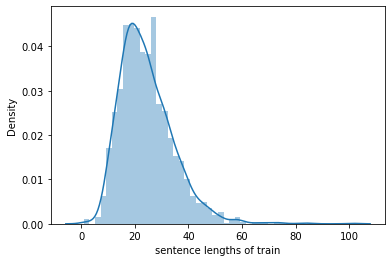


Description of document lengths of train :
Count: 350
Sum: 45412
Min: 26
Mean: 129.74857142857144
Max: 334


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


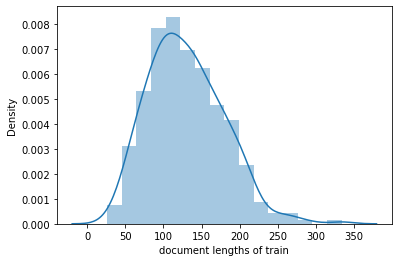


Description of ' ner ' in train
Total: 5598
Material : 542
OtherScientificTerm : 1536
Generic : 950
Method : 1445
Task : 894
Metric : 231


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


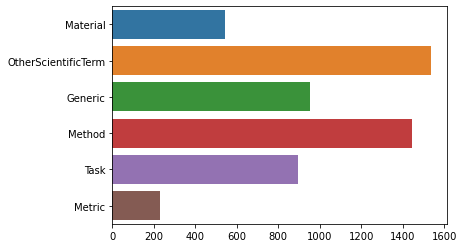

Description of ' relations ' in train
Total: 3219
CONJUNCTION : 400
FEATURE-OF : 173
HYPONYM-OF : 298
USED-FOR : 1690
PART-OF : 179
COMPARE : 166
EVALUATE-FOR : 313


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


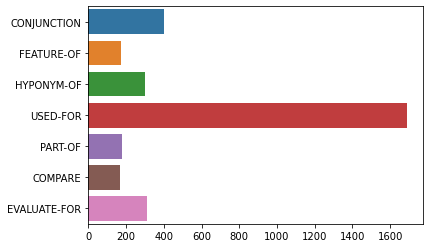

---------------------------------------------------------------------------------
Description of dev dataset:
Description of sentence lengths of dev :
Count: 275
Sum: 6521
Min: 8
Mean: 23.71272727272727
Max: 68


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


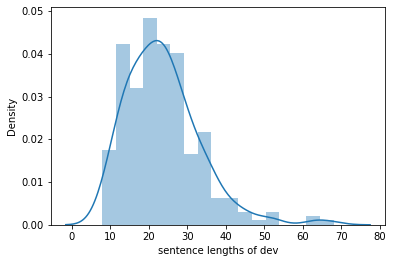


Description of document lengths of dev :
Count: 50
Sum: 6521
Min: 46
Mean: 130.42
Max: 226


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


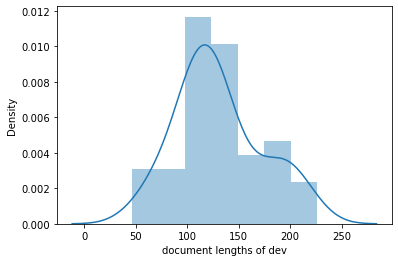


Description of ' ner ' in dev
Total: 811
Generic : 147
Task : 127
Material : 71
OtherScientificTerm : 212
Method : 216
Metric : 38


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


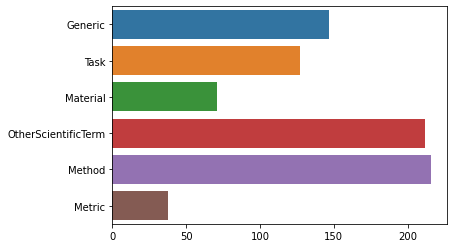

Description of ' relations ' in dev
Total: 455
USED-FOR : 214
FEATURE-OF : 32
CONJUNCTION : 59
HYPONYM-OF : 44
PART-OF : 27
EVALUATE-FOR : 50
COMPARE : 29


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


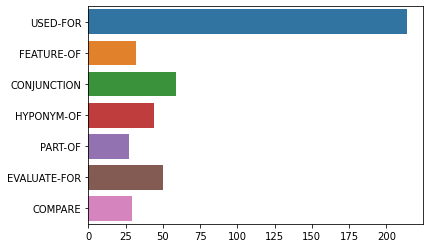

---------------------------------------------------------------------------------
Description of test dataset:
Description of sentence lengths of test :
Count: 551
Sum: 13401
Min: 5
Mean: 24.321234119782215
Max: 97


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


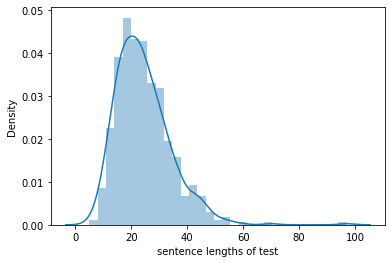


Description of document lengths of test :
Count: 100
Sum: 13401
Min: 43
Mean: 134.01
Max: 313


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


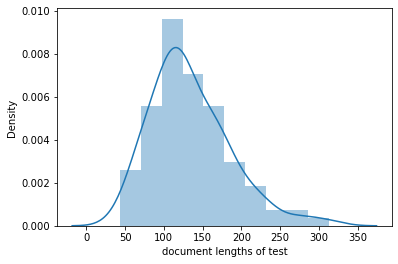


Description of ' ner ' in test
Total: 1685
Task : 263
OtherScientificTerm : 522
Material : 158
Generic : 241
Method : 430
Metric : 71


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


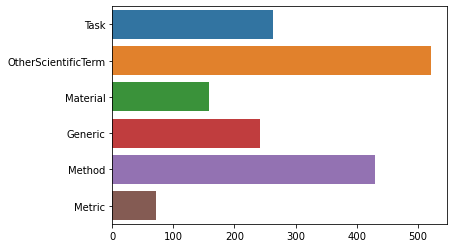

Description of ' relations ' in test
Total: 974
PART-OF : 63
USED-FOR : 533
HYPONYM-OF : 67
CONJUNCTION : 123
FEATURE-OF : 59
EVALUATE-FOR : 91
COMPARE : 38


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


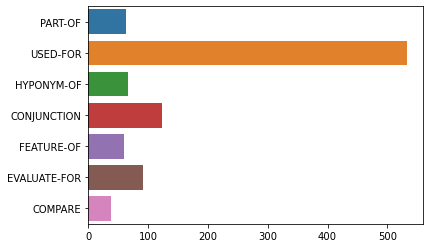

---------------------------------------------------------------------------------
There are 0 cross sentence relations group train
There are 0 cross sentence relations group dev
There are 0 cross sentence relations group test


In [21]:
describe_data()

In [22]:
def get_token_id(words):
    """Tokenize each word in a list of words
    Return a list of lists of token ids
    """
    token_id = []
    for word in words:
        # apply [1:-1] to remore CLS and SEP token ids at the begin and the end of the list
        token_id.append(tokenizer(word)["input_ids"][1:-1])
    return token_id

In [30]:
def expand_token_id(token_ids, words, sentence_embedding, entities):
    """Expand token id and duplicate members in other lists wherever necessary"""
    # Test if all lists have the same length as expected
    try:
        assert len(token_ids) == len(words) == len(sentence_embedding)
    except AssertionError:
        print("Input lists do not have the same length, abort")
        return token_ids, words, sentence_embedding, entities
    new_token_ids = []
    new_words = []
    new_sentence_embedding = []
    id_range = {}
    last = 0
    for i in range(len(token_ids)):
        for tid in token_ids[i]:
            new_token_ids.append(tid)
            new_words.append(words[i])
            new_sentence_embedding.append(sentence_embedding[i])
        id_range[i] = (last, len(new_token_ids))
        last = len(new_token_ids)
    for key in entities:
        entities[key]["begin"] = id_range[entities[key]["begin"]][0] 
        entities[key]["end"] = id_range[entities[key]["end"]-1][1]
    return new_token_ids, new_words, new_sentence_embedding, entities

In [31]:
def extract_doc(document):
    """Extract data from a document"""
    doc_id = document["doc_key"]
    words = []
    sentence_embedding = []
    entities = {}
    entity_span = {}
    relations = {}
    entity_count = 0
    relation_count = 0
    # Parse the words
    for i in range(len(document["sentences"])):
        for word in document["sentences"][i]:
            words.append(word)
            sentence_embedding.append(i)
    # Parse the entities
    for i in range(len(document["ner"])):
        for entity in document["ner"][i]:
            entity_count += 1
            entities[entity_count] = {"type": entity_encode[entity[2]], 
                                      "begin": entity[0], "end": entity[1] + 1}
            entity_span[(entity[0], entity[1] + 1)] = entity_count
    # Parse the relations
    for i in range(len(document["relations"])):
        for relation in document["relations"][i]:
            relation_count += 1
            relations[relation_count] = {"type": relation_encode[relation[4]], 
                                         "source": entity_span[(relation[0], relation[1] + 1)],
                                         "target": entity_span[(relation[2], relation[3] + 1)]}
    # Tokenize and expand
    token_ids = get_token_id(words)
    data_frame = pd.DataFrame()
    data_frame["token_ids"], data_frame["words"], data_frame["sentence_embedding"], entities = \
        expand_token_id(token_ids, words, sentence_embedding, entities)
    data_frame["tokens"] = tokenizer.convert_ids_to_tokens(data_frame["token_ids"]) 
    return {"document": doc_id,
            "data_frame": data_frame,
            "entities": entities,
            "relations": relations}

In [32]:
docs = get_docs("train")
extract_doc(docs[1])["document"]

'CVPR_2003_18_abs'

In [33]:
pd.set_option('display.max_rows', 500)
extract_doc(docs[1])["data_frame"]

,token_ids,words,sentence_embedding,tokens
0,1999,In,0,in
1,2023,this,0,this
2,3259,paper,0,paper
3,1010,",",0,","
4,1037,a,0,a
5,3117,novel,0,novel
6,4118,method,0,method
7,2000,to,0,to
8,4553,learn,0,learn
9,1996,the,0,the


In [35]:
extract_doc(docs[1])["entities"]

{1: {'type': 5, 'begin': 6, 'end': 7},
 2: {'type': 2, 'begin': 10, 'end': 13},
 3: {'type': 1, 'begin': 14, 'end': 17},
 4: {'type': 2, 'begin': 26, 'end': 30},
 5: {'type': 2, 'begin': 33, 'end': 36},
 6: {'type': 5, 'begin': 53, 'end': 60},
 7: {'type': 1, 'begin': 61, 'end': 71},
 8: {'type': 5, 'begin': 68, 'end': 71},
 9: {'type': 2, 'begin': 74, 'end': 81},
 10: {'type': 5, 'begin': 89, 'end': 92},
 11: {'type': 5, 'begin': 99, 'end': 101},
 12: {'type': 2, 'begin': 106, 'end': 109},
 13: {'type': 5, 'begin': 113, 'end': 118},
 14: {'type': 5, 'begin': 124, 'end': 127},
 15: {'type': 5, 'begin': 138, 'end': 141},
 16: {'type': 5, 'begin': 142, 'end': 147},
 17: {'type': 4, 'begin': 157, 'end': 158},
 18: {'type': 4, 'begin': 163, 'end': 165},
 19: {'type': 1, 'begin': 167, 'end': 174},
 20: {'type': 2, 'begin': 169, 'end': 174},
 21: {'type': 2, 'begin': 176, 'end': 178},
 22: {'type': 2, 'begin': 179, 'end': 184},
 23: {'type': 2, 'begin': 186, 'end': 191},
 24: {'type': 4, 'be

In [36]:
extract_doc(docs[1])["relations"]

{1: {'type': 2, 'source': 1, 'target': 2},
 2: {'type': 2, 'source': 2, 'target': 3},
 3: {'type': 5, 'source': 5, 'target': 4},
 4: {'type': 2, 'source': 6, 'target': 7},
 5: {'type': 2, 'source': 11, 'target': 10},
 6: {'type': 1, 'source': 12, 'target': 13},
 7: {'type': 2, 'source': 15, 'target': 16},
 8: {'type': 7, 'source': 17, 'target': 18},
 9: {'type': 2, 'source': 17, 'target': 19},
 10: {'type': 2, 'source': 18, 'target': 19},
 11: {'type': 3, 'source': 21, 'target': 20},
 12: {'type': 5, 'source': 22, 'target': 21},
 13: {'type': 4, 'source': 22, 'target': 23},
 14: {'type': 5, 'source': 23, 'target': 21},
 15: {'type': 2, 'source': 24, 'target': 25}}

In [37]:
def extract_data(group):
    """Extract all documents to a dataset"""
    docs = get_docs(group)
    data = []
    for document in docs:
        data.append(extract_doc(document))
    return data

In [41]:
def check_extracted_data(data):
    """Check if all extracted data is valid"""
    for item in data:
        document_name = item["document"]
        data_frame = item["data_frame"]
        entities = item["entities"]
        relations = item["relations"]

        # Check if sentence embedding are correct
        sentence_embedding = data_frame["sentence_embedding"].tolist()
        for i in range(1, len(sentence_embedding)):
            try:
                assert 0 <= sentence_embedding[i] - sentence_embedding[i - 1] <= 1
            except AssertionError:
                print("Check failed at document", document_name, "in 'sentence_embedding' at position",
                      i, "sentence_embedding[i] - sentence_embedding[i-1] =",
                      sentence_embedding[i] - sentence_embedding[i - 1])

        # Check if all relations are valid
        for value in relations.values():
            first = value["source"]
            second = value["target"]
            try:
                assert first in entities
            except AssertionError:
                print("Check failed at document", document_name, "in 'relations',", first,
                      "is not found in record")
            try:
                assert second in entities
            except AssertionError:
                print("Check failed at document", document_name, "in 'relations',", second,
                      "is not found in record")


In [42]:
data = extract_data("train") + extract_data("dev") + extract_data("test")

In [43]:
check_extracted_data(data)